In [242]:
import numpy as np
import pandas as pd
import copy as copy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline
import os.path
import glob
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [243]:
os. chdir('/IBA/upwork/project1')
dff = pd.read_csv('output_data.csv')

In [244]:
def process_training_data(dff):

    dff.drop(dff.columns[0],axis = 1, inplace = True)
    dff.drop(dff.columns[0],axis = 1, inplace = True)

    predictionsdff = copy.deepcopy(dff['output_own_price'])

    for index in range(len(dff)):
        if index % 364 == 0 and index != len(dff):
            dff.drop(dff.index[index+364], inplace=True)

        if index % 364 == 0 and index != len(dff):
            predictionsdff.drop(predictionsdff.index[index],inplace=True)
            
    df = dff
    predictions = predictionsdff

    # df.to_excel("processed.xlsx", index=False)
    # predictions.to_excel("pred.xlsx", index=False)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(df))
    normalizer(df).numpy()
    
    return df,predictions,normalizer

In [245]:
def train_model(df,predictions,normalizer):

    model = Sequential(
        [            
        normalizer,            
        Dense(64, activation='relu'),
        Dense(64, activation='relu'), 
        Dense(25, activation='relu'), 
        Dense(15, activation='relu'), 
        Dense(1)  
        
        ],
        ) 
    [layer1, layer2, layer3,layer4,layer5,Layer6] = model.layers

    model.compile(
        loss=tf.keras.losses.MeanAbsolutePercentageError(),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    bmw = model.fit(
        df,
        predictions,
        epochs=1000,
        verbose = 0,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2,
        )

    hist = pd.DataFrame(bmw.history)
    model.save('pred_model_client')


    return model

In [246]:
def predict_price(model,testdata):

    testdata.drop(testdata.columns[0],axis = 1, inplace = True)
    testdata.drop(testdata.columns[0],axis = 1, inplace = True)
    
    testtensor = tf.convert_to_tensor(testdata,  dtype=tf.float32)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(testtensor))
    normalizer(testtensor).numpy()

    testdatapredictions = model.predict(testtensor).flatten()
    predictionpd = pd.DataFrame (testdatapredictions)

    predictionpd.to_excel("testdatapredictionsfinal.xlsx", index=False)

    return predictionpd
    

In [247]:
df,predictions,normalizer = process_training_data(dff)

model = train_model(df,predictions,normalizer)

testdata  = pd.read_csv('output_data.csv')
testpred  = pd.read_csv('testpredictions.csv')

testdatapredictionsfinal=predict_price(model,testdata)

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


616/616 [==============================] - 1s 1ms/step


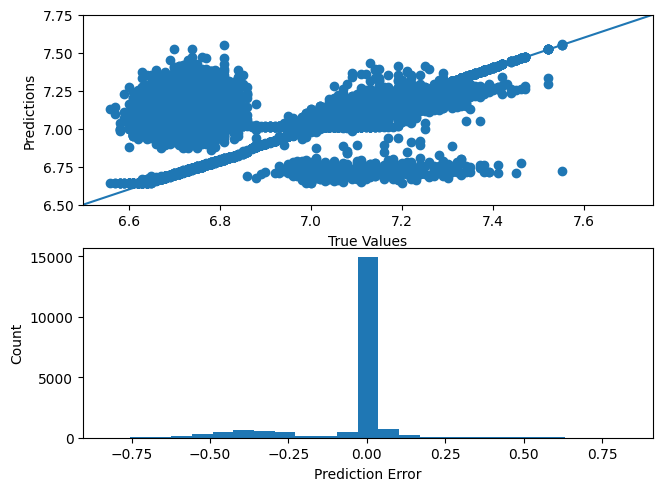

Percentage Error is 1.06 %


In [248]:
figure, axis = plt.subplots(2 )
figure.tight_layout(pad=1.0)

axis[0].plot(aspect='equal')
axis[0].scatter(testpred, testdatapredictionsfinal)
axis[0].set(xlabel='True Values')
axis[0].set(ylabel='Predictions')
axis[0].lims = [6.5,7.75 ]
axis[0].set(xlim=(axis[0].lims))
axis[0].set(ylim=(axis[0].lims))
axis[0].plot(axis[0].lims, axis[0].lims)

error = np.subtract(testpred,np.asarray(testdatapredictionsfinal))

axis[1].hist(error, bins=25)
axis[1].set(xlabel='Prediction Error')
axis[1].set(ylabel='Count')

plt.show()

testpred, testdatapredictionsfinal = np.array(testpred), np.array(testdatapredictionsfinal)

MAPE = round(np.mean(np.abs((testpred - testdatapredictionsfinal) / testpred)) * 100, 2)

print("Percentage Error is " +str(MAPE)+" %")